# Aprendizado Profundo - UFMG

## Passo à Passo das Redes Neurais

A criação e treinamento de uma rede neural tem alguns passos que foram um *pipeline* completo.
Nesta aula, vamos ver cada passo para criar e treinar uma rede neural do zero usando MXNet.


Antes de começar, vamos instalar o MXNet. Esse pequeno bloco de código abaixo é usado somente para instalar o MXNet para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

Configure também o Collab para fazer uso de GPUs.

Clique em "Runtime" depois "Change Runtime" e por altere as configurações da seguinte forma:

![](https://www.kdnuggets.com/wp-content/uploads/colab-settings-1.png)

Lembre-se de instalar o mxnet com gpu, descomente o código abaixo.

In [1]:
# ! pip install mxnet-cu100

O próximo bloco contém nossos importes. O mais importante aqui é o gluon. Gluon é uma API mais alto nível para criação de redes neurais. Por baixo, temos um código estilo o de backpragation da aula passada. Porém, é bem melhor :-) Mais rápido, usa GPUs, carrega dados etc.

Note como fazemos import de várias partes do gluon. Um código completo com mxnet + gluon vai fazer algo como:

```python
from mxnet import autograd
from mxnet import gluon
from mxnet import init
from mxnet import nd

from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
from mxnet.gluon import utils```

O próximo abaixo configura o mxnet para fazer uso de GPUs.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [2]:
from mxnet import autograd
from mxnet import gluon
from mxnet import init
from mxnet import nd

from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
from mxnet.gluon import utils

import os
import sys
import time
import mxnet as mx

In [3]:
import matplotlib.pyplot as plt
plt.ion()

In [4]:
# Tenta encontrar GPU
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

# CTX é um contexto mxnet, caso exista GPU o código rola nela. Caso não, executa na CPU mesmo.
ctx = try_gpu()
ctx

cpu(0)

## Passo 1: Carregar os dados

Para treinar qualquer modelo de aprendizado de máquina, devemos carregar os dados.
Caso o modelo seja não supervisionado, teremos os dados somente.
Já para modelos treinados supervisionadamente, teremos os dados e os rótulos (também conhecidos como *labels* ou *ground-truths*).

Obserne como o MXNET importa dados, pelo menos os didáticos, de forma muito simples.

In [5]:
mnist_train = gdata.vision.MNIST(train=True)
mnist_test = gdata.vision.MNIST(train=False)

Cada conjunto acima agora é um iterador. Podemos passar pelos elementos

In [6]:
for xi, yi in mnist_train:
    print(xi.shape)
    print(yi)
    break

(28, 28, 1)
5


No loop acima, vemos que o treino é uma image de 28, 28 por 1. A resposta é uma classe. A base é bem similar com as outras que usamo junto com skimage.

In [7]:
for xi, yi in mnist_train:
    print(type(xi))
    print(type(yi))
    break

<class 'mxnet.ndarray.ndarray.NDArray'>
<class 'numpy.int32'>


O X é um TENSOR, o teste um inteiro. Como esperado, temos o número 5. Cada imagem é um número.

Observe que precisei fazer um reshape para plotar, pois original o mxnet trabalha com tensores. Então, converti para uma imagem: (28, 28, 1) -> (28, 28)

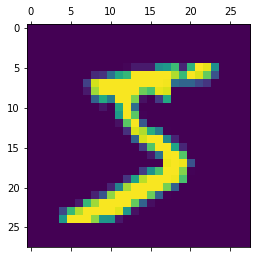

In [8]:
for xi, yi in mnist_train:
    Img = xi.reshape((28, 28))
    plt.matshow(Img.asnumpy())
    break

Vamos supor que nossa ideia fosse fazer uso de um multiplayer perceptron simples. O mesmo trabalha em cima de uma vetor. Portanto, temos que converter imagem ao carregar. Para isto, podemos fazer uso de um Transformer. Existe um mundo de [Transformers](https://mxnet.incubator.apache.org/api/python/gluon/data.html). Use o comando help para entender os mesmos.

In [9]:
help(gdata.vision.transforms.Cast)
gdata.vision.transforms.ToTensor
gdata.vision.transforms.Resize
gdata.vision.transforms.Normalize

Help on class Cast in module mxnet.gluon.data.vision.transforms:

class Cast(mxnet.gluon.block.HybridBlock)
 |  Cast input to a specific data type
 |  
 |  Parameters
 |  ----------
 |  dtype : str, default 'float32'
 |      The target data type, in string or `numpy.dtype`.
 |  
 |  
 |  Inputs:
 |      - **data**: input tensor with arbitrary shape.
 |  
 |  Outputs:
 |      - **out**: output tensor with the same shape as `data`.
 |  
 |  Method resolution order:
 |      Cast
 |      mxnet.gluon.block.HybridBlock
 |      mxnet.gluon.block.Block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dtype='float32')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  hybrid_forward(self, F, x)
 |      Overrides to construct symbolic graph for this `Block`.
 |      
 |      Parameters
 |      ----------
 |      x : Symbol or NDArray
 |          The first input tensor.
 |      *args : list of Symbol or list of NDArray
 |          Additio

mxnet.gluon.data.vision.transforms.Normalize

Vamos supor que você queira trabalhar com uma imagem em float32. Use um transformer!

In [10]:
xi, yi = next(iter(mnist_train))
print(xi.dtype)

<class 'numpy.uint8'>


In [11]:
transform = gdata.vision.transforms.Cast('float32')
xi_new = transform(xi)
print(xi_new.dtype)

<class 'numpy.float32'>


Podemos criar nossos transformers também! Por baixo são funções simples.

In [12]:
def transform(xi, yi):
    return xi.reshape(28*28).astype('float32'), yi.astype('float32')

In [13]:
xi_new, yi_new = transform(xi, yi)
print(xi_new.shape)

(784,)


Jogamos o transformer no carregamento dos dados e voilà!

In [14]:
mnist_train = gdata.vision.MNIST(train=True, transform=transform)
mnist_test = gdata.vision.MNIST(train=False, transform=transform)

In [ ]:
for xi, yi in mnist_train:
    print(xi.shape)
    print(xi.dtype)
    break

(784,)
<class 'numpy.float32'>


Com a classe `gluon.data.DataLoader` conseguimos iterar pela base em minibatches. Esta é a ideia para executar um Minibatch-GD (abaixo).

In [ ]:
mnist_train = gdata.vision.MNIST(train=True, transform=transform)
mnist_test = gdata.vision.MNIST(train=False, transform=transform)

In [ ]:
minibatch_train = gluon.data.DataLoader(mnist_train, 50)
minibatch_test = gluon.data.DataLoader(mnist_test, 50)

In [ ]:
for xi, yi in minibatch_train:
    print(xi.shape) # note como carregamos 50 vetores de tamanho 784
    print(xi.dtype)
    break

(50, 784)
<class 'numpy.float32'>


Uma prática comum que você pode ter nos seus dados é criar pastas de imagem de treino, teste e validação. Não temos isto pronto no notebook mas seria algo como o código abaixo. Note o uso de um `gluon.data.vision.ImageFolderDataset`.

```python
# loading the data and apply pre-processing(transforms) on images
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path), transform=transformer,
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path), transform=transformer,
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path), transform=transformer,
    batch_size=batch_size, shuffle=False, num_workers=num_workers)
```

## Passo 2: Definir a arquitetura

Um modelo deve ser definito para ser treinado usando os dados desejados.
No caso de redes neurais, criaremos uma nova arquitetura.
Tal arquitetura pode ser composta de diversos tipos de camadas como, por exemplo, [Densas](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Dense) (camadas totalmente conectadas como as que implementamos do zero), [convolucionais](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Conv2D), e [recorrentes](https://mxnet.incubator.apache.org/api/python/gluon/rnn.html#mxnet.gluon.rnn.RNN).
Veremos todas essas camadas ao longo do curso.

O código abaixo cria uma rede simples MLP. Note como a mesma tem 10 saídas. A entrada não é definida, o mxnet é inteligente suficiente para adivinhar o formato da camada-zero usando os dados.

(sim, o reshape de antes não serve de nada, mas ok, ajuda para aprender)

In [ ]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01)) # valores iniciais são uma normal

## Passo 3: Definir a função de custo (função de perda ou *loss*)

Funções de perda, também conhecidas como *loss functions*, são muito importantes para o aprendizagem de máquinas, pois servem como uma forma de medir a distância ou a diferença entre a saída prevista de um modelo e o seu valor real, auxiliando então no treino no modelo.

Diversas funções de perda foram propostas ao longo do tempo para diferentes tipos de problemas.
Algumas dessas funções foram propostas para auxiliar no treino de modelos de regressão linear, como as *loss* [L1](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.L2Loss), [L2](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.L1Loss).
Já outras foram propostas para problemas de classificação, como [Hinge](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.HingeLoss), e [Cross Entropy](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss).

Veremos várias funções de custo mais adiante no curso.
Neste primeiro momento, focaremos na função [Cross Entropy](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss)  combinada com a ativação [Softmax](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.softmax), pois é a combinação mais comum nos dias de hoje para a tarefa de classificação.

O pequeno bloco de código abaixo implementa essa função de perda em MXNet.

In [ ]:
# função de custo (ou loss)
cross_entropy = gloss.SoftmaxCrossEntropyLoss()

## Passo 4: Definir o algoritmo de otimização

Definimos uma arquitetura, composta de diversos pesos geralmente inicializados aleatoriamente, e definimos também uma função que custo que nos permite avaliar o quão bem esta rede neural está.
Entretanto, para que possamos alterar os pesos e fazer a rede convergir para um bom resultados, devemos definir um algoritmo de otimização, que usará derivadas parciais da função de custo em relação àos pesos para otimizar a rede.

Diversos algoritmos foram propostos ao longo dos anos como, por exemplo, [Stochastic Gradient Descent (SGD)](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.SGD), [Adam](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.Adam), e [RMSProp](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.RMSProp).
Veremos mais adianta sobre cada um desses algoritmos.
Nesse primeiro momento, usaremos o algoritmo mais comum: [Stochastic Gradient Descent (SGD)](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.SGD).

O código abaixo implementa uma função de otimização usando o SGD para otimizar todos os parâmetros da rede neural proposta.

In [ ]:
# trainer do gluon
lr = 0.5
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

### Treinando

A partir deste momento já podemos treinar! Observe como a biblioteca permite de forma muito simples uma implementação do gradiente descendente

In [ ]:
# 1. Carrega dados
mnist_train = gdata.vision.MNIST(train=True, transform=transform)
mnist_test = gdata.vision.MNIST(train=False, transform=transform)

# 2. Define mini-batch
minibatch_train = gluon.data.DataLoader(mnist_train, 50)
minibatch_test = gluon.data.DataLoader(mnist_test, 50)

# 3. Define rede

net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01)) # valores iniciais são uma normal

# 4. Define loss e treinamento
cross_entropy = gloss.SoftmaxCrossEntropyLoss()
lr = 0.01
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

Agora, treine!

In [ ]:
iteracoes_treino = 5
for i in range(iteracoes_treino):         # número de iterações, não verificamos convergencia
    cumulative_loss = 0
    for data, y in minibatch_train:       # para cada minibatch
        with mx.autograd.record():        # indicando que vamos derivar
            P = net(data)                 # execute o softmax, retorne as probabilidades, forward
            loss = cross_entropy(P, y)    # compute a perda
        loss.backward()                   # atualiza os pesos com backward, nosso backprop de antes
        trainer.step(data.shape[0])       # atualize os parâmetros com a derivada
        cumulative_loss += nd.sum(loss).asscalar()
    print('Iteração {}. Perda {}'.format(i, cumulative_loss / len(data)))

Iteração 0. Perda 321026.04389816284
Iteração 1. Perda 241787.25541369236
Iteração 2. Perda 235761.69261037826
Iteração 3. Perda 223252.19299560785
Iteração 4. Perda 222016.5436442566


Podemos treinar aquiteturas mais complicadas. Abaixo, treinaremos uma arquitetura baseada na [LeNet-5](https://ieeexplore.ieee.org/document/726791).

Notem que, além de definir o tipo da camada, é necessário também definir a sua ativação.
Existem diversos tipos de ativações como, por exemplo, [ReLU](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.relu), [LeakyReLU](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.LeakyReLU), e [sigmoid](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.sigmoid).
Neste primeiro momento, usaremos somente a ReLU.
Porém, veremos mais de perto várias outras ativações ao longo deste curso.

O trecho de código abaixo implementa uma rede simples usando [ReLUs](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Symbol.relu) no framework MXNet.

In [ ]:
# 1. Carrega dados
mnist_train = gdata.vision.MNIST(train=True, transform=transform)
mnist_test = gdata.vision.MNIST(train=False, transform=transform)

# 2. Define mini-batch
minibatch_train = gluon.data.DataLoader(mnist_train, 50)
minibatch_test = gluon.data.DataLoader(mnist_test, 50)

# 3. Define rede

net = nn.Sequential()
net.add(nn.Dense(128, activation='relu'),
        nn.Dense(64, activation='relu'),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01), ctx=ctx) # observe aqui o uso do ctx! use a GPU!!

# 4. Define loss e treinamento
cross_entropy = gloss.SoftmaxCrossEntropyLoss()
lr = 0.5
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

Observe como nessa rede nova a perda é bem menor logo de cara, parece melhor!

In [ ]:
iteracoes_treino = 5
for i in range(iteracoes_treino):         # número de iterações, não verificamos convergencia
    cumulative_loss = 0
    for data, y in minibatch_train:       # para cada minibatch
        with mx.autograd.record():        # indicando que vamos derivar
            P = net(data)                 # execute o softmax, retorne as probabilidades, forward
            loss = cross_entropy(P, y)    # compute a perda
        loss.backward()                   # atualiza os pesos com backward, nosso backprop de antes
        trainer.step(data.shape[0])       # atualize os parâmetros com a derivada
        cumulative_loss += nd.sum(loss).asscalar()
    print('Iteração {}. Perda {}'.format(i, cumulative_loss / len(data)))

Iteração 0. Perda 151687940459.7088
Iteração 1. Perda 5673.456030120849
Iteração 2. Perda 2764.4041192626955
Iteração 3. Perda 2764.4041186523436
Iteração 4. Perda 2764.4041143798827


Abaixo rodamos um minibatch apenas. Note como a rede gera previsões. Para cada instância, temos 10 elementos da camada final. A probabilidade de cada classe!

In [ ]:
for data, y in minibatch_test: 
    P = net(data)                # faça uma previsão
    print(P.shape)
    break

(50, 10)


Abaixo avaliamos a acurácia no teste.

Note o use da classe `mx.metric.Accuracy()`. A mesma acumula resultados para cada minibatch do teste. Sim, é esquisito, mas deixa a ideia de iterar por batches consistente em treino/teste.

In [ ]:
from mxnet import metric

acc = metric.Accuracy()
i = 0
for data, y in minibatch_test:            # para cada minibatch do teste
    P = net(data)                         # faça uma previsão
    pred = P.argmax(axis=1)               # pegue a classe mais provavel
    acc.update(preds = pred, labels = y)  # atualize a accuracy
print(acc)

EvalMetric: {'accuracy': 0.1028}


## Passo 5: Colando Tudo Junto


No geral, não vamos fazer isso sempre do zero. 

Portanto, abaixo implementamos algumas funções auxiliares. As mesmas carregam os dados, quebram treinam e validam, reportam métricas. Vamos usar elas nos outros notebooks.

Portanto, criamos conjuntos de treino/validação. Este é último passo para então treinar a rede neural. Abixo, temos uma função que que recebe os dados, a rede, o *loss*, e o algoritmo de otimização, e realmente converge o modelo.

In [ ]:
## carregando dados

# código para carregar o dataset do MNIST
# http://yann.lecun.com/exdb/mnist/
def load_data_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'mnist')):
    """Download the MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    mnist_train = gdata.vision.MNIST(root=root, train=True)
    mnist_test = gdata.vision.MNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

# funções básicas
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n, l = nd.array([0]), 0, 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            # X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            y = y.astype('float32')
            y_hat = net(X)
            l += loss(y_hat, y).sum()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n, l.asscalar() / n
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss, ctx,
                   num_epochs):
    print('training on', ctx)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss, ctx)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

In [ ]:
# carregamento do dado: mnist
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size)

In [ ]:
# criando a rede
net = nn.Sequential()
net.add(nn.Dense(128, activation='relu'),
        nn.Dense(64, activation='relu'),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01), ctx=ctx) # observe aqui o uso do ctx! use a GPU!!

cross_entropy = gloss.SoftmaxCrossEntropyLoss()
lr = 0.5
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

In [ ]:
num_epochs = 10
train_validate(net, train_iter, test_iter, batch_size, trainer, cross_entropy, 
               ctx, num_epochs)

training on cpu(0)
